# Hymba 아키텍처 비교 평가

이 노트북에서는 직접 구현한 백본을 활용하여 다양한 아키텍처를 비교 평가합니다.

## 비교 대상
1. **Mamba-only**: SSM 기반 순수 Mamba 모델
2. **Transformer-only**: 순수 Attention 기반 모델
3. **Hymba (직접 구현)**: Attention + Mamba 하이브리드
4. **Hymba (공식)**: NVIDIA 공식 구현

## 목차
1. 환경 설정
2. 모델 설정 및 생성
3. 학습 및 비교
4. 성능 비교 시각화
5. Attention Map 분석

In [1]:
import sys
import os
import warnings
import gc

sys.path.insert(0, './backbone')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
from tqdm.auto import tqdm
from typing import Dict, List, Optional, Tuple, Any

# 한글 폰트 설정 + 마이너스 기호 깨짐 방지
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
    name='NanumGothicBold')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({
    'font.size': 12, 
    'font.family': 'NanumGothicBold',
    'axes.unicode_minus': False  # 마이너스 기호 깨짐 방지
})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name()}')

RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

torch.manual_seed(42)
np.random.seed(42)

Device: cuda
GPU: NVIDIA A100 80GB PCIe


---
## 2. 모델 설정

4가지 아키텍처를 동일한 파라미터 규모로 비교합니다.

In [2]:
from hymba import Hymba, HymbaConfig, ArchType, AttentionType
from hymba_official import HymbaOfficialModel, HymbaOfficialConfig

# ============================================================
# 공통 설정 (파라미터 수 ~28M 맞춤)
# ============================================================
VOCAB_SIZE = 50257  # GPT-2 토크나이저

# ============================================================
# 1. Mamba-only 설정 (28.05M params)
# ============================================================
config_mamba = HymbaConfig(
    vocab_size=VOCAB_SIZE,
    d_model=320,
    n_layers=8,
    n_heads=5,
    n_kv_heads=1,
    arch_type=ArchType.MAMBA_ONLY,
    use_meta_tokens=False,
)

# ============================================================
# 2. Transformer-only 설정 (27.80M params - 11 layers로 맞춤)
# ============================================================
config_transformer = HymbaConfig(
    vocab_size=VOCAB_SIZE,
    d_model=320,
    n_layers=11,  # 레이어 수 증가로 파라미터 맞춤
    n_heads=5,
    n_kv_heads=1,
    arch_type=ArchType.TRANSFORMER_ONLY,
    global_attn_idx=list(range(11)),  # 모든 레이어가 Global
    use_meta_tokens=False,
)

# ============================================================
# 3. Hymba (직접 구현) 설정 (29.96M params)
# ============================================================
config_hymba = HymbaConfig(
    vocab_size=VOCAB_SIZE,
    d_model=320,
    n_layers=8,
    n_heads=5,
    n_kv_heads=1,
    arch_type=ArchType.HYBRID,
    global_attn_idx=[0, 4, 7],  # 일부만 Global
    swa_window=64,  # Local attention 효과 확인을 위해 줄임
    use_meta_tokens=True,
    num_meta_tokens=64,
)

# ============================================================
# 4. Hymba (공식 구현) 설정 - 파라미터 규모 맞춤 (~27.5M)
# ============================================================
config_hymba_official = HymbaOfficialConfig(
    vocab_size=VOCAB_SIZE,
    hidden_size=320,  # 직접 구현과 동일
    num_hidden_layers=8,
    num_attention_heads=5,
    num_key_value_heads=1,
    mamba_expand=2,
    mamba_d_state=16,
    mamba_d_conv=4,
    intermediate_size=512,  # FFN 추가로 파라미터 맞춤
    global_attn_idx=[0, 4, 7],  # 직접 구현과 동일
    num_memory_tokens=64,
    attn_window_size=64,  # Local attention 효과 확인을 위해 줄임
    max_seq_len=512,
)

# 설정 출력
print('=' * 70)
print('모델 설정 비교 (파라미터 수 ~28M 맞춤)')
print('=' * 70)

configs = {
    'Mamba-only': config_mamba,
    'Transformer-only': config_transformer,
    'Hymba (직접 구현)': config_hymba,
}

for name, cfg in configs.items():
    print(f'\n{name}:')
    print(f'  - arch_type: {cfg.arch_type.name}')
    print(f'  - d_model: {cfg.d_model}, n_layers: {cfg.n_layers}')
    print(f'  - meta_tokens: {cfg.num_meta_tokens if cfg.use_meta_tokens else "None"}')
    if hasattr(cfg, 'swa_window'):
        print(f'  - swa_window: {cfg.swa_window}')

print(f'\nHymba (공식 구현):')
print(f'  - hidden_size: {config_hymba_official.hidden_size}, n_layers: {config_hymba_official.num_hidden_layers}')
print(f'  - global_attn_idx: {config_hymba_official.global_attn_idx}')
print(f'  - meta_tokens: {config_hymba_official.num_memory_tokens}')
print(f'  - attn_window_size: {config_hymba_official.attn_window_size}')
print(f'  - intermediate_size: {config_hymba_official.intermediate_size}')

모델 설정 비교 (파라미터 수 ~28M 맞춤)

Mamba-only:
  - arch_type: MAMBA_ONLY
  - d_model: 320, n_layers: 8
  - meta_tokens: None
  - swa_window: 1024

Transformer-only:
  - arch_type: TRANSFORMER_ONLY
  - d_model: 320, n_layers: 11
  - meta_tokens: None
  - swa_window: 1024

Hymba (직접 구현):
  - arch_type: HYBRID
  - d_model: 320, n_layers: 8
  - meta_tokens: 64
  - swa_window: 64

Hymba (공식 구현):
  - hidden_size: 320, n_layers: 8
  - global_attn_idx: [0, 4, 7]
  - meta_tokens: 64
  - attn_window_size: 64
  - intermediate_size: 512


In [3]:
# 모델 생성 및 파라미터 수 확인
print('=' * 70)
print('모델 생성 및 파라미터 수')
print('=' * 70)

model_info = {}

# 직접 구현 모델들
for name, cfg in configs.items():
    model = Hymba(cfg)
    params = model.count_parameters()
    model_info[name] = {
        'config': cfg,
        'params': params['total'],
        'params_m': params['total'] / 1e6,
    }
    print(f'{name}: {params["total"]/1e6:.2f}M params')
    del model

# 공식 구현 모델
model_official = HymbaOfficialModel(config_hymba_official)
params_official = model_official.count_parameters()
model_info['Hymba (공식)'] = {
    'config': config_hymba_official,
    'params': params_official['total'],
    'params_m': params_official['total'] / 1e6,
}
print(f'Hymba (공식): {params_official["total"]/1e6:.2f}M params')
del model_official

torch.cuda.empty_cache()
gc.collect()

모델 생성 및 파라미터 수
Mamba-only: 28.05M params
Transformer-only: 27.80M params
Hymba (직접 구현): 29.96M params
Hymba (공식): 27.46M params


0

---
## 3. 데이터셋 및 학습 설정

In [4]:
# 데이터셋 로드
from datasets import load_dataset
from transformers import AutoTokenizer

print('데이터셋 로드 중...')
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# 토큰화
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512, padding='max_length')

tokenized = dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized.set_format('torch')

print(f'토큰화 완료: {len(tokenized)} samples')

데이터셋 로드 중...
토큰화 완료: 36718 samples


In [5]:
# ============================================================
# 학습 설정 및 함수
# ============================================================

from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
import math
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    """학습 설정"""
    batch_size: int = 32
    gradient_accumulation_steps: int = 4
    learning_rate: float = 3e-4
    min_lr: float = 1e-5
    weight_decay: float = 0.1
    max_grad_norm: float = 1.0
    num_epochs: int = 10  # 10 에포크로 조정
    warmup_ratio: float = 0.1
    use_amp: bool = True
    amp_dtype: torch.dtype = torch.float16
    max_steps_per_epoch: int = 200
    log_steps: int = 50


def get_scheduler(optimizer, num_warmup_steps, num_training_steps, min_lr_ratio=0.1):
    """Linear warmup + Cosine annealing"""
    def lr_lambda(step):
        if step < num_warmup_steps:
            return float(step) / float(max(1, num_warmup_steps))
        progress = float(step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(min_lr_ratio, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return LambdaLR(optimizer, lr_lambda)


def train_model(model, dataloader, config, device, model_name='Model'):
    """모델 학습 및 결과 반환"""
    model = model.to(device)
    model.train()
    
    # Optimizer
    no_decay = ['bias', 'norm', 'layernorm', 'embed']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() 
                   if not any(nd in n.lower() for nd in no_decay) and p.requires_grad],
         'weight_decay': config.weight_decay},
        {'params': [p for n, p in model.named_parameters() 
                   if any(nd in n.lower() for nd in no_decay) and p.requires_grad],
         'weight_decay': 0.0}
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.learning_rate, betas=(0.9, 0.95))
    
    total_steps = config.max_steps_per_epoch * config.num_epochs
    warmup_steps = int(total_steps * config.warmup_ratio)
    scheduler = get_scheduler(optimizer, warmup_steps, total_steps, config.min_lr / config.learning_rate)
    scaler = GradScaler('cuda', enabled=config.use_amp)
    
    # 학습 기록
    history = {'loss': [], 'ppl': [], 'time': []}
    global_step = 0
    
    print(f'\n{"="*60}')
    print(f'{model_name} 학습 시작')
    print(f'{"="*60}')
    
    for epoch in range(config.num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        optimizer.zero_grad()
        
        start_time = time.time()
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{config.num_epochs}', total=config.max_steps_per_epoch, leave=False)
        
        for step, batch in enumerate(pbar):
            if step >= config.max_steps_per_epoch:
                break
            
            inputs = batch['input_ids'].to(device)
            
            with autocast(device_type='cuda', dtype=config.amp_dtype, enabled=config.use_amp):
                output = model(inputs, targets=inputs)
                loss = output['loss'] / config.gradient_accumulation_steps
            
            scaler.scale(loss).backward()
            
            if (step + 1) % config.gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()
                global_step += 1
            
            epoch_loss += loss.item() * config.gradient_accumulation_steps
            num_batches += 1
            
            if (step + 1) % config.log_steps == 0:
                avg_loss = epoch_loss / num_batches
                pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'ppl': f'{np.exp(avg_loss):.2f}'})
        
        elapsed = time.time() - start_time
        avg_loss = epoch_loss / num_batches
        avg_ppl = np.exp(avg_loss)
        
        history['loss'].append(avg_loss)
        history['ppl'].append(avg_ppl)
        history['time'].append(elapsed)
        
        # 매 2 에포크마다 출력
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f'  Epoch {epoch+1:2d}: Loss={avg_loss:.4f}, PPL={avg_ppl:.2f}, Time={elapsed:.1f}s')
    
    print(f'  Final   : Loss={history["loss"][-1]:.4f}, PPL={history["ppl"][-1]:.2f}')
    return model, history


train_config = TrainingConfig()
print('학습 설정:')
print(f'  - Effective batch size: {train_config.batch_size * train_config.gradient_accumulation_steps}')
print(f'  - Max steps/epoch: {train_config.max_steps_per_epoch}')
print(f'  - Total epochs: {train_config.num_epochs}')
print(f'  - Total steps: {train_config.max_steps_per_epoch * train_config.num_epochs}')

학습 설정:
  - Effective batch size: 128
  - Max steps/epoch: 200
  - Total epochs: 10
  - Total steps: 2000


---
## 4. 모델별 학습 및 비교

In [ ]:
# DataLoader 생성
train_dataloader = DataLoader(
    tokenized,
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

# 결과 저장
all_results = {}
trained_models = {}

In [7]:
# ============================================================
# 1. Mamba-only 학습
# ============================================================
torch.cuda.empty_cache()
gc.collect()

model_mamba = Hymba(config_mamba)
model_mamba, history_mamba = train_model(
    model_mamba, train_dataloader, train_config, device, 'Mamba-only'
)

all_results['Mamba-only'] = {
    'params_m': model_info['Mamba-only']['params_m'],
    'final_loss': history_mamba['loss'][-1],
    'final_ppl': history_mamba['ppl'][-1],
    'total_time': sum(history_mamba['time']),
    'history': history_mamba,
}
trained_models['Mamba-only'] = model_mamba


Mamba-only 학습 시작


Epoch 1/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  1: Loss=6.0697, PPL=432.54, Time=19.0s


Epoch 2/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  2: Loss=3.1937, PPL=24.38, Time=18.2s


Epoch 3/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  4: Loss=0.2800, PPL=1.32, Time=18.2s


Epoch 5/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  6: Loss=0.0893, PPL=1.09, Time=18.2s


Epoch 7/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  8: Loss=0.0315, PPL=1.03, Time=18.2s


Epoch 9/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch 10: Loss=0.0167, PPL=1.02, Time=18.2s
  Final   : Loss=0.0167, PPL=1.02


In [8]:
# ============================================================
# 2. Transformer-only 학습
# ============================================================
torch.cuda.empty_cache()
gc.collect()

model_transformer = Hymba(config_transformer)
model_transformer, history_transformer = train_model(
    model_transformer, train_dataloader, train_config, device, 'Transformer-only'
)

all_results['Transformer-only'] = {
    'params_m': model_info['Transformer-only']['params_m'],
    'final_loss': history_transformer['loss'][-1],
    'final_ppl': history_transformer['ppl'][-1],
    'total_time': sum(history_transformer['time']),
    'history': history_transformer,
}
trained_models['Transformer-only'] = model_transformer


Transformer-only 학습 시작


Epoch 1/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  1: Loss=6.6431, PPL=767.44, Time=23.0s


Epoch 2/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  2: Loss=3.5906, PPL=36.26, Time=22.9s


Epoch 3/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  4: Loss=0.5056, PPL=1.66, Time=22.9s


Epoch 5/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  6: Loss=0.1511, PPL=1.16, Time=22.9s


Epoch 7/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  8: Loss=0.0521, PPL=1.05, Time=22.9s


Epoch 9/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch 10: Loss=0.0244, PPL=1.02, Time=22.9s
  Final   : Loss=0.0244, PPL=1.02


In [9]:
# ============================================================
# 3. Hymba (직접 구현) 학습
# ============================================================
torch.cuda.empty_cache()
gc.collect()

model_hymba = Hymba(config_hymba)
model_hymba, history_hymba = train_model(
    model_hymba, train_dataloader, train_config, device, 'Hymba (직접 구현)'
)

all_results['Hymba (직접 구현)'] = {
    'params_m': model_info['Hymba (직접 구현)']['params_m'],
    'final_loss': history_hymba['loss'][-1],
    'final_ppl': history_hymba['ppl'][-1],
    'total_time': sum(history_hymba['time']),
    'history': history_hymba,
}
trained_models['Hymba (직접 구현)'] = model_hymba


Hymba (직접 구현) 학습 시작


Epoch 1/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  1: Loss=6.4654, PPL=642.52, Time=32.5s


Epoch 2/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  2: Loss=3.3373, PPL=28.14, Time=32.5s


Epoch 3/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  4: Loss=0.2903, PPL=1.34, Time=32.4s


Epoch 5/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  6: Loss=0.0735, PPL=1.08, Time=32.4s


Epoch 7/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  8: Loss=0.0299, PPL=1.03, Time=32.4s


Epoch 9/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch 10: Loss=0.0147, PPL=1.01, Time=32.4s
  Final   : Loss=0.0147, PPL=1.01


In [10]:
# ============================================================
# 4. Hymba (공식) 학습
# ============================================================
torch.cuda.empty_cache()
gc.collect()

model_hymba_official = HymbaOfficialModel(config_hymba_official)
model_hymba_official, history_hymba_official = train_model(
    model_hymba_official, train_dataloader, train_config, device, 'Hymba (공식)'
)

all_results['Hymba (공식)'] = {
    'params_m': model_info['Hymba (공식)']['params_m'],
    'final_loss': history_hymba_official['loss'][-1],
    'final_ppl': history_hymba_official['ppl'][-1],
    'total_time': sum(history_hymba_official['time']),
    'history': history_hymba_official,
}
trained_models['Hymba (공식)'] = model_hymba_official


Hymba (공식) 학습 시작


Epoch 1/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  1: Loss=6.8057, PPL=903.02, Time=44.3s


Epoch 2/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  2: Loss=3.6947, PPL=40.23, Time=44.3s


Epoch 3/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  4: Loss=0.3480, PPL=1.42, Time=44.3s


Epoch 5/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  6: Loss=0.0934, PPL=1.10, Time=44.3s


Epoch 7/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch  8: Loss=0.0346, PPL=1.04, Time=44.3s


Epoch 9/10:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/200 [00:00<?, ?it/s]

  Epoch 10: Loss=0.0169, PPL=1.02, Time=44.3s
  Final   : Loss=0.0169, PPL=1.02


---
## 5. 성능 비교 시각화

In [11]:
# ============================================================
# 성능 비교 테이블
# ============================================================
print('=' * 70)
print('모델 성능 비교')
print('=' * 70)

comparison_data = []
for name, result in all_results.items():
    steps_per_sec = (train_config.max_steps_per_epoch * train_config.num_epochs) / result['total_time']
    comparison_data.append({
        'Model': name,
        'Params (M)': f"{result['params_m']:.2f}",
        'Final Loss': f"{result['final_loss']:.4f}",
        'Final PPL': f"{result['final_ppl']:.2f}",
        'Time (s)': f"{result['total_time']:.1f}",
        'Steps/sec': f"{steps_per_sec:.2f}",
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# CSV 저장
df_comparison.to_csv(f'{RESULTS_DIR}/model_comparison.csv', index=False)
print(f'\n저장: {RESULTS_DIR}/model_comparison.csv')

모델 성능 비교
           Model Params (M) Final Loss Final PPL Time (s) Steps/sec
      Mamba-only      28.05     0.0167      1.02    183.1     10.92
Transformer-only      27.80     0.0244      1.02    229.1      8.73
   Hymba (직접 구현)      29.96     0.0147      1.01    324.5      6.16
      Hymba (공식)      27.46     0.0169      1.02    442.8      4.52

저장: ./results/model_comparison.csv


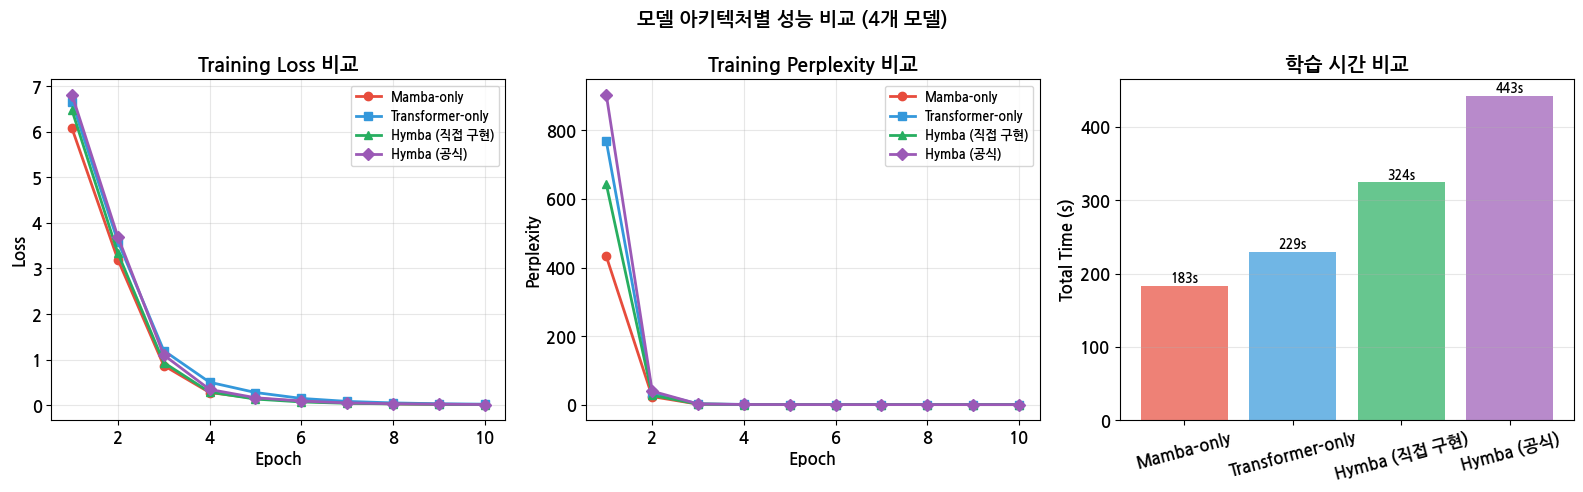

저장: ./results/model_comparison.png


In [12]:
# ============================================================
# 학습 곡선 비교 (4개 모델)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = {
    'Mamba-only': '#E74C3C', 
    'Transformer-only': '#3498DB', 
    'Hymba (직접 구현)': '#27AE60',
    'Hymba (공식)': '#9B59B6'
}
markers = {
    'Mamba-only': 'o', 
    'Transformer-only': 's', 
    'Hymba (직접 구현)': '^',
    'Hymba (공식)': 'D'
}

epochs = range(1, train_config.num_epochs + 1)

# Loss 비교
ax1 = axes[0]
for name, result in all_results.items():
    ax1.plot(epochs, result['history']['loss'], f'{markers[name]}-', 
             color=colors[name], label=name, linewidth=2, markersize=6)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss 비교')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# PPL 비교
ax2 = axes[1]
for name, result in all_results.items():
    ax2.plot(epochs, result['history']['ppl'], f'{markers[name]}-', 
             color=colors[name], label=name, linewidth=2, markersize=6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Training Perplexity 비교')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 학습 시간 비교
ax3 = axes[2]
model_names = list(all_results.keys())
times = [all_results[n]['total_time'] for n in model_names]
bars = ax3.bar(model_names, times, color=[colors[n] for n in model_names], alpha=0.7)
ax3.set_ylabel('Total Time (s)')
ax3.set_title('학습 시간 비교')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=15)

# 값 표시
for bar, t in zip(bars, times):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{t:.0f}s', ha='center', va='bottom', fontsize=9)

plt.suptitle('모델 아키텍처별 성능 비교 (4개 모델)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/model_comparison.png')

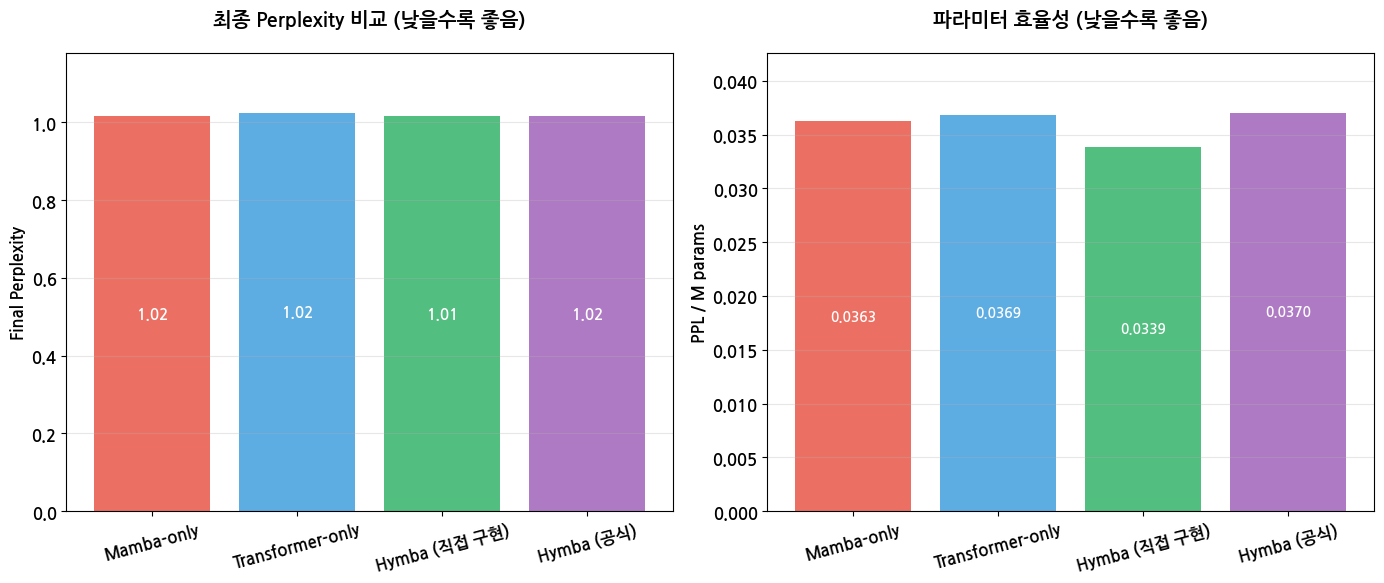

저장: ./results/final_comparison.png


In [13]:
# ============================================================
# 최종 성능 막대 그래프 (4개 모델) - 수치값 위치 수정
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 높이 증가

model_names = list(all_results.keys())

# Final PPL 비교
ax1 = axes[0]
ppls = [all_results[n]['final_ppl'] for n in model_names]
bars1 = ax1.bar(model_names, ppls, color=[colors[n] for n in model_names], alpha=0.8)
ax1.set_ylabel('Final Perplexity')
ax1.set_title('최종 Perplexity 비교 (낮을수록 좋음)', pad=20)  # 제목 패딩 추가
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=15)

# 수치값을 막대 내부에 표시
for bar, ppl in zip(bars1, ppls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height * 0.5, 
             f'{ppl:.2f}', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Y축 상단 여백 추가
ax1.set_ylim(0, max(ppls) * 1.15)

# 파라미터 대비 성능 (PPL/M params)
ax2 = axes[1]
efficiency = [all_results[n]['final_ppl'] / all_results[n]['params_m'] for n in model_names]
bars2 = ax2.bar(model_names, efficiency, color=[colors[n] for n in model_names], alpha=0.8)
ax2.set_ylabel('PPL / M params')
ax2.set_title('파라미터 효율성 (낮을수록 좋음)', pad=20)  # 제목 패딩 추가
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=15)

# 수치값을 막대 내부에 표시
for bar, eff in zip(bars2, efficiency):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height * 0.5, 
             f'{eff:.4f}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# Y축 상단 여백 추가
ax2.set_ylim(0, max(efficiency) * 1.15)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/final_comparison.png')

---
## 6. Attention Map 분석

Hymba의 Global/Local Attention 패턴과 Meta Token Attention을 시각화합니다.

In [14]:
# ============================================================
# Attention Map 추출 - Hymba (직접 구현) 및 공식 구현
# ============================================================
model_hymba = trained_models['Hymba (직접 구현)']
model_hymba.eval()

model_hymba_off = trained_models['Hymba (공식)']
model_hymba_off.eval()

# 테스트 입력
test_seq_len = 128  # 더 긴 시퀀스로 SWA 패턴 확인
test_input = torch.randint(0, VOCAB_SIZE, (1, test_seq_len), device=device)

# 직접 구현 모델 attention
with torch.no_grad():
    output_mine = model_hymba(test_input, return_attn=True)
attn_weights_mine = output_mine['attn_weights']
num_meta = config_hymba.num_meta_tokens
swa_window = config_hymba.swa_window

# 공식 구현 모델 attention
with torch.no_grad():
    output_official = model_hymba_off(test_input, return_attn=True)
attn_weights_official = output_official['attn_weights']
num_meta_official = config_hymba_official.num_memory_tokens
swa_window_official = config_hymba_official.attn_window_size

print(f'직접 구현 - Attention layers: {len(attn_weights_mine)}')
print(f'  Meta tokens: {num_meta}, SWA window: {swa_window}')
print(f'  Content tokens: {test_seq_len}')

print(f'\n공식 구현 - Attention layers: {len(attn_weights_official)}')
print(f'  Meta tokens: {num_meta_official}, SWA window: {swa_window_official}')
print(f'  Content tokens: {test_seq_len}')

직접 구현 - Attention layers: 8
  Meta tokens: 64, SWA window: 64
  Content tokens: 128

공식 구현 - Attention layers: 8
  Meta tokens: 64, SWA window: 64
  Content tokens: 128


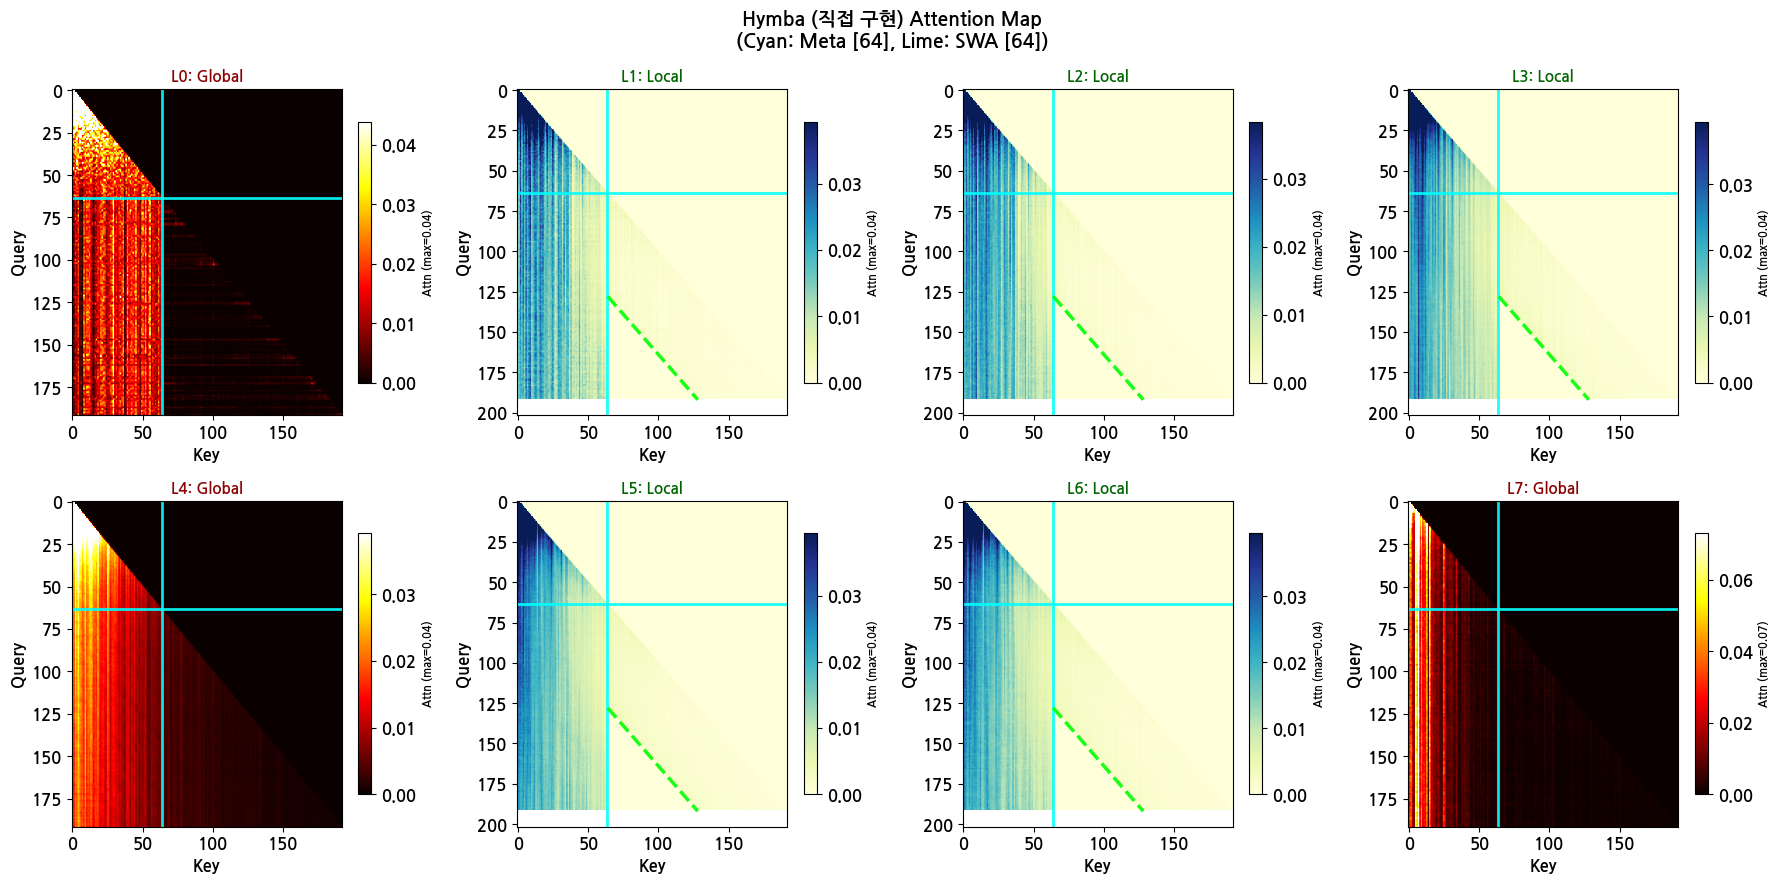

저장: ./results/hybrid_mine_attention_maps.png


In [15]:
# ============================================================
# 레이어별 Attention Map 시각화 (개선된 스케일 및 colormap)
# ============================================================
n_layers = config_hymba.n_layers
global_layers = set(config_hymba.global_attn_idx)

def plot_attention_map(ax, attn, num_meta, swa_window, layer_idx, is_global, vmax_percentile=99):
    """
    Attention map with improved visualization
    - percentile 기반 vmax로 outlier 제외
    - 더 선명한 colormap 사용
    """
    # Percentile 기반으로 상위 outlier 제외한 max 값 사용
    vmax = np.percentile(attn, vmax_percentile)
    vmax = max(vmax, 0.01)  # 최소값 보장
    
    # 더 선명한 colormap: 'hot'은 attention 시각화에 효과적
    cmap = 'hot' if is_global else 'YlGnBu'
    
    im = ax.imshow(attn, cmap=cmap, aspect='auto', vmin=0, vmax=vmax)
    
    T = attn.shape[0]  # 전체 시퀀스 길이 (meta + content)
    
    # Meta token 경계선 (cyan color for better visibility)
    if num_meta > 0:
        ax.axvline(x=num_meta - 0.5, color='cyan', linestyle='-', linewidth=2, alpha=0.9)
        ax.axhline(y=num_meta - 0.5, color='cyan', linestyle='-', linewidth=2, alpha=0.9)
    
    # SWA 경계 표시 (Local attention인 경우만)
    if not is_global and num_meta > 0:
        content_len = T - num_meta
        if swa_window < content_len:
            y_start = num_meta + swa_window
            x_start = num_meta
            y_end = T
            x_end = T - swa_window
            
            if y_start < T:
                ax.plot([x_start, x_end], [y_start, y_end], 
                       color='lime', linestyle='--', linewidth=2.5, alpha=0.9)
    
    return im, vmax


# 직접 구현 모델 attention map
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for layer_idx in range(n_layers):
    ax = axes[layer_idx]
    is_global = layer_idx in global_layers
    
    if attn_weights_mine[layer_idx] is not None:
        # [batch, heads, seq+meta, seq+meta] -> 평균
        attn = attn_weights_mine[layer_idx][0].mean(dim=0).cpu().numpy()
        
        im, vmax_used = plot_attention_map(ax, attn, num_meta, swa_window, layer_idx, is_global)
        
        layer_type = 'Global' if is_global else 'Local'
        ax.set_title(f'L{layer_idx}: {layer_type}', fontsize=11, fontweight='bold',
                    color='#8B0000' if is_global else '#006400')
        
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')
        
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label(f'Attn (max={vmax_used:.2f})', fontsize=8)
    else:
        ax.text(0.5, 0.5, 'Mamba Only\n(No Attention)', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Layer {layer_idx}: Mamba', fontsize=11)

plt.suptitle(f'Hymba (직접 구현) Attention Map\n(Cyan: Meta [{num_meta}], Lime: SWA [{swa_window}])', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/hybrid_mine_attention_maps.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/hybrid_mine_attention_maps.png')

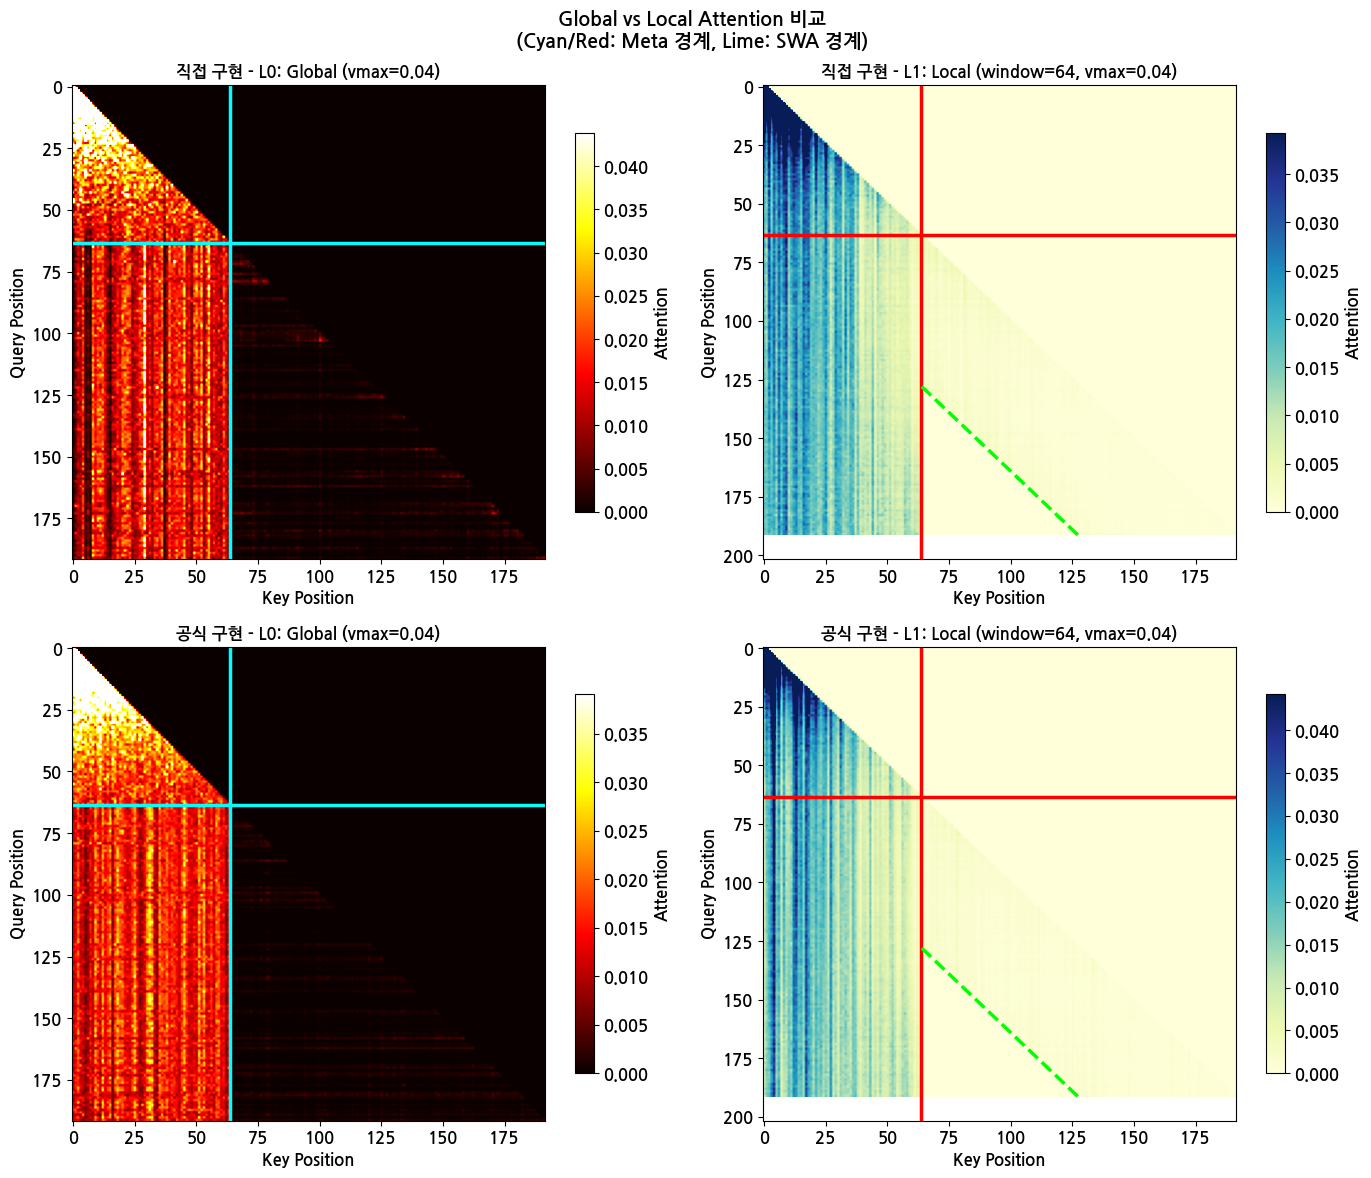

저장: ./results/global_vs_local_attention.png


In [16]:
# ============================================================
# Global vs Local Attention 상세 비교 (개선된 시각화)
# ============================================================
global_idx = config_hymba.global_attn_idx[0]  # 첫 번째 Global 레이어
local_idx = [i for i in range(n_layers) if i not in global_layers][0]  # 첫 번째 Local 레이어

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

def get_vmax(attn, percentile=99):
    """상위 outlier 제외한 적절한 vmax 계산"""
    return max(np.percentile(attn, percentile), 0.01)

# ===== 상단: 직접 구현 모델 =====
# Global Attention (직접 구현)
ax1 = axes[0, 0]
attn_global = attn_weights_mine[global_idx][0].mean(dim=0).cpu().numpy()
vmax1 = get_vmax(attn_global)
im1 = ax1.imshow(attn_global, cmap='hot', aspect='auto', vmin=0, vmax=vmax1)
ax1.axvline(x=num_meta - 0.5, color='cyan', linestyle='-', linewidth=2.5)
ax1.axhline(y=num_meta - 0.5, color='cyan', linestyle='-', linewidth=2.5)
ax1.set_title(f'직접 구현 - L{global_idx}: Global (vmax={vmax1:.2f})', fontsize=12, fontweight='bold')
ax1.set_xlabel('Key Position')
ax1.set_ylabel('Query Position')
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Attention')

# Local (SWA) Attention (직접 구현)
ax2 = axes[0, 1]
attn_local = attn_weights_mine[local_idx][0].mean(dim=0).cpu().numpy()
vmax2 = get_vmax(attn_local)
im2 = ax2.imshow(attn_local, cmap='YlGnBu', aspect='auto', vmin=0, vmax=vmax2)
ax2.axvline(x=num_meta - 0.5, color='red', linestyle='-', linewidth=2.5)
ax2.axhline(y=num_meta - 0.5, color='red', linestyle='-', linewidth=2.5)

# SWA 경계 - Content 영역 내에서 올바른 위치에 표시
T = attn_local.shape[0]
content_len = T - num_meta
if swa_window < content_len:
    y_start = num_meta + swa_window
    x_start = num_meta
    y_end = T
    x_end = T - swa_window
    ax2.plot([x_start, x_end], [y_start, y_end], color='lime', linestyle='--', linewidth=2.5)

ax2.set_title(f'직접 구현 - L{local_idx}: Local (window={swa_window}, vmax={vmax2:.2f})', fontsize=12, fontweight='bold')
ax2.set_xlabel('Key Position')
ax2.set_ylabel('Query Position')
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Attention')

# ===== 하단: 공식 구현 모델 =====
global_official_idx = config_hymba_official.global_attn_idx[0]
local_official_idx = [i for i in range(config_hymba_official.num_hidden_layers) 
                      if i not in set(config_hymba_official.global_attn_idx)][0]

# Global Attention (공식 구현)
ax3 = axes[1, 0]
if attn_weights_official[global_official_idx] is not None:
    attn_global_off = attn_weights_official[global_official_idx][0].mean(dim=0).cpu().numpy()
    vmax3 = get_vmax(attn_global_off)
    im3 = ax3.imshow(attn_global_off, cmap='hot', aspect='auto', vmin=0, vmax=vmax3)
    ax3.axvline(x=num_meta_official - 0.5, color='cyan', linestyle='-', linewidth=2.5)
    ax3.axhline(y=num_meta_official - 0.5, color='cyan', linestyle='-', linewidth=2.5)
    cbar3 = plt.colorbar(im3, ax=ax3, shrink=0.8)
    cbar3.set_label('Attention')
    ax3.set_title(f'공식 구현 - L{global_official_idx}: Global (vmax={vmax3:.2f})', fontsize=12, fontweight='bold')
else:
    ax3.set_title(f'공식 구현 - L{global_official_idx}: Global (No data)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Key Position')
ax3.set_ylabel('Query Position')

# Local (SWA) Attention (공식 구현)
ax4 = axes[1, 1]
if attn_weights_official[local_official_idx] is not None:
    attn_local_off = attn_weights_official[local_official_idx][0].mean(dim=0).cpu().numpy()
    vmax4 = get_vmax(attn_local_off)
    im4 = ax4.imshow(attn_local_off, cmap='YlGnBu', aspect='auto', vmin=0, vmax=vmax4)
    ax4.axvline(x=num_meta_official - 0.5, color='red', linestyle='-', linewidth=2.5)
    ax4.axhline(y=num_meta_official - 0.5, color='red', linestyle='-', linewidth=2.5)
    
    T_off = attn_local_off.shape[0]
    content_len_off = T_off - num_meta_official
    if swa_window_official < content_len_off:
        y_start_off = num_meta_official + swa_window_official
        x_start_off = num_meta_official
        y_end_off = T_off
        x_end_off = T_off - swa_window_official
        ax4.plot([x_start_off, x_end_off], [y_start_off, y_end_off], color='lime', linestyle='--', linewidth=2.5)
    
    cbar4 = plt.colorbar(im4, ax=ax4, shrink=0.8)
    cbar4.set_label('Attention')
    ax4.set_title(f'공식 구현 - L{local_official_idx}: Local (window={swa_window_official}, vmax={vmax4:.2f})', fontsize=12, fontweight='bold')
else:
    ax4.set_title(f'공식 구현 - L{local_official_idx}: Local (No data)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Key Position')
ax4.set_ylabel('Query Position')

plt.suptitle(f'Global vs Local Attention 비교\n(Cyan/Red: Meta 경계, Lime: SWA 경계)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/global_vs_local_attention.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/global_vs_local_attention.png')

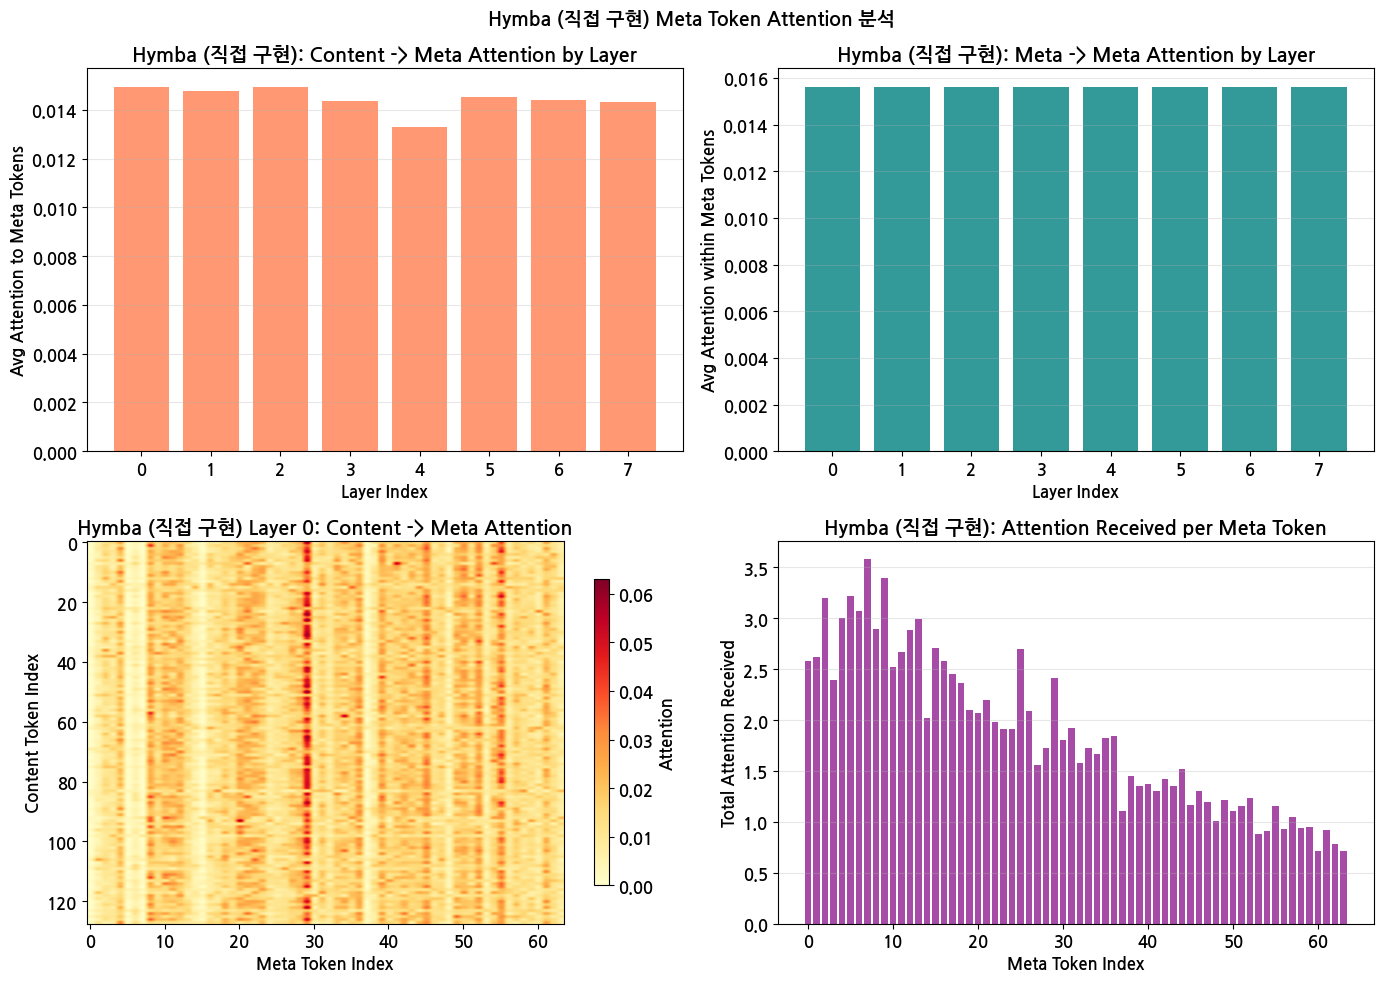

저장: ./results/meta_token_attention.png


In [17]:
# ============================================================
# Meta Token Attention 분석 (선형 스케일)
# Content → Meta attention 패턴 시각화
# ============================================================
def analyze_meta_attention(attn_weights, num_meta, model_name='Model'):
    """Meta token attention 분석"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Content → Meta attention (각 레이어별)
    ax1 = axes[0, 0]
    content_to_meta_per_layer = []
    
    for layer_idx, attn in enumerate(attn_weights):
        if attn is not None:
            # [batch, heads, T, T] -> 평균
            attn_avg = attn[0].mean(dim=0).cpu().numpy()
            # Content query → Meta key attention 평균
            content_to_meta = attn_avg[num_meta:, :num_meta].mean()
            content_to_meta_per_layer.append((layer_idx, content_to_meta))
    
    if content_to_meta_per_layer:
        layers, values = zip(*content_to_meta_per_layer)
        ax1.bar(layers, values, color='coral', alpha=0.8)
        ax1.set_xlabel('Layer Index')
        ax1.set_ylabel('Avg Attention to Meta Tokens')
        ax1.set_title(f'{model_name}: Content -> Meta Attention by Layer')
        ax1.grid(True, alpha=0.3, axis='y')
    
    # Meta → Meta attention (self-attention within meta tokens)
    ax2 = axes[0, 1]
    meta_to_meta_per_layer = []
    
    for layer_idx, attn in enumerate(attn_weights):
        if attn is not None:
            attn_avg = attn[0].mean(dim=0).cpu().numpy()
            # Meta query → Meta key attention 평균
            meta_to_meta = attn_avg[:num_meta, :num_meta].mean()
            meta_to_meta_per_layer.append((layer_idx, meta_to_meta))
    
    if meta_to_meta_per_layer:
        layers, values = zip(*meta_to_meta_per_layer)
        ax2.bar(layers, values, color='teal', alpha=0.8)
        ax2.set_xlabel('Layer Index')
        ax2.set_ylabel('Avg Attention within Meta Tokens')
        ax2.set_title(f'{model_name}: Meta -> Meta Attention by Layer')
        ax2.grid(True, alpha=0.3, axis='y')
    
    # Position별 Content → Meta attention heatmap (선형 스케일)
    ax3 = axes[1, 0]
    for layer_idx, attn in enumerate(attn_weights):
        if attn is not None:
            attn_avg = attn[0].mean(dim=0).cpu().numpy()
            content_to_meta_map = attn_avg[num_meta:, :num_meta]
            
            im3 = ax3.imshow(content_to_meta_map, cmap='YlOrRd', aspect='auto', 
                            vmin=0, vmax=content_to_meta_map.max())
            ax3.set_xlabel('Meta Token Index')
            ax3.set_ylabel('Content Token Index')
            ax3.set_title(f'{model_name} Layer {layer_idx}: Content -> Meta Attention')
            plt.colorbar(im3, ax=ax3, shrink=0.8, label='Attention')
            break
    
    # Meta token별 총 attention received
    ax4 = axes[1, 1]
    meta_attention_received = []
    
    for layer_idx, attn in enumerate(attn_weights):
        if attn is not None:
            attn_avg = attn[0].mean(dim=0).cpu().numpy()
            # 각 meta token이 받는 attention 총량 (content query로부터)
            meta_received = attn_avg[num_meta:, :num_meta].sum(axis=0)
            meta_attention_received.append(meta_received)
    
    if meta_attention_received:
        avg_received = np.mean(meta_attention_received, axis=0)
        ax4.bar(range(len(avg_received)), avg_received, color='purple', alpha=0.7)
        ax4.set_xlabel('Meta Token Index')
        ax4.set_ylabel('Total Attention Received')
        ax4.set_title(f'{model_name}: Attention Received per Meta Token')
        ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'{model_name} Meta Token Attention 분석', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


# 직접 구현 모델 분석
fig_mine = analyze_meta_attention(attn_weights_mine, num_meta, 'Hymba (직접 구현)')
plt.savefig(f'{RESULTS_DIR}/meta_token_attention.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'저장: {RESULTS_DIR}/meta_token_attention.png')

SWA (Sliding Window Attention) Window Size 검토

현재 설정:
  - 직접 구현 SWA window: 64
  - 공식 구현 SWA window: 64
  - 테스트 시퀀스 길이: 128
  - Meta token 수: 64

Local (SWA) 레이어: [1, 2, 3, 5, 6]


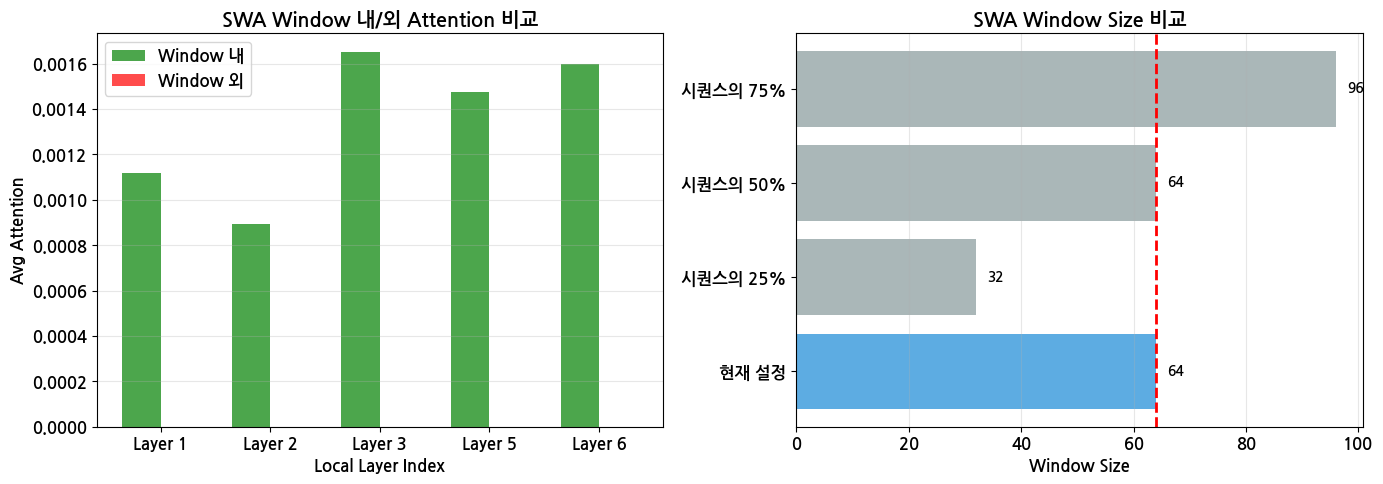


[ SWA Window Size 분석 결과 ]
  - 현재 window: 64 (시퀀스 길이의 50.0%)
  - 효과적 범위: window 크기가 시퀀스 길이보다 크면 Global과 동일
  ✓ 현재 window 크기가 적절함 (시퀀스 내에서 local attention 효과 발휘)

저장: ./results/swa_window_analysis.png


In [18]:
# ============================================================
# SWA Window Size 적절성 검토
# ============================================================
print('=' * 70)
print('SWA (Sliding Window Attention) Window Size 검토')
print('=' * 70)

# 현재 설정
print(f'\n현재 설정:')
print(f'  - 직접 구현 SWA window: {swa_window}')
print(f'  - 공식 구현 SWA window: {swa_window_official}')
print(f'  - 테스트 시퀀스 길이: {test_seq_len}')
print(f'  - Meta token 수: {num_meta}')

# Local attention 레이어에서 실제 attention 분포 분석
local_layers_mine = [i for i in range(n_layers) if i not in global_layers]

print(f'\nLocal (SWA) 레이어: {local_layers_mine}')

# SWA window 효과 분석
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 윈도우 내/외 attention 비교
ax1 = axes[0]
in_window_attention = []
out_window_attention = []

for layer_idx in local_layers_mine:
    if attn_weights_mine[layer_idx] is not None:
        attn = attn_weights_mine[layer_idx][0].mean(dim=0).cpu().numpy()
        T = attn.shape[0]
        
        # Content → Content 영역만 분석
        content_attn = attn[num_meta:, num_meta:]
        content_len = content_attn.shape[0]
        
        # 윈도우 내/외 attention 분리
        in_win = 0.0
        out_win = 0.0
        in_count = 0
        out_count = 0
        
        for q in range(content_len):
            for k in range(content_len):
                if k <= q:  # causal만 고려
                    if q - k < swa_window:
                        in_win += content_attn[q, k]
                        in_count += 1
                    else:
                        out_win += content_attn[q, k]
                        out_count += 1
        
        if in_count > 0:
            in_window_attention.append(in_win / in_count)
        if out_count > 0:
            out_window_attention.append(out_win / out_count)

if in_window_attention and out_window_attention:
    x = np.arange(len(local_layers_mine))
    width = 0.35
    ax1.bar(x - width/2, in_window_attention, width, label='Window 내', color='green', alpha=0.7)
    ax1.bar(x + width/2, out_window_attention, width, label='Window 외', color='red', alpha=0.7)
    ax1.set_xlabel('Local Layer Index')
    ax1.set_ylabel('Avg Attention')
    ax1.set_title('SWA Window 내/외 Attention 비교')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Layer {l}' for l in local_layers_mine])
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

# Window size 권장사항
ax2 = axes[1]
# 시퀀스 길이 대비 윈도우 크기 비율
window_ratio = swa_window / test_seq_len
content_ratio = swa_window / (test_seq_len)

recommendations = [
    ('현재 설정', swa_window),
    ('시퀀스의 25%', int(test_seq_len * 0.25)),
    ('시퀀스의 50%', int(test_seq_len * 0.5)),
    ('시퀀스의 75%', int(test_seq_len * 0.75)),
]

labels, values = zip(*recommendations)
colors_bar = ['#3498DB' if l == '현재 설정' else '#95A5A6' for l in labels]
ax2.barh(labels, values, color=colors_bar, alpha=0.8)
ax2.set_xlabel('Window Size')
ax2.set_title('SWA Window Size 비교')
ax2.axvline(x=swa_window, color='red', linestyle='--', linewidth=2, label=f'현재: {swa_window}')
ax2.grid(True, alpha=0.3, axis='x')

for i, v in enumerate(values):
    ax2.text(v + 2, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/swa_window_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 권장사항 출력
print(f'\n[ SWA Window Size 분석 결과 ]')
print(f'  - 현재 window: {swa_window} (시퀀스 길이의 {window_ratio*100:.1f}%)')
print(f'  - 효과적 범위: window 크기가 시퀀스 길이보다 크면 Global과 동일')

if swa_window >= test_seq_len:
    print(f'  ⚠️ 현재 window가 시퀀스 길이 이상이므로 실질적으로 Global attention과 동일')
    print(f'     → 더 긴 시퀀스에서 테스트하거나 window 크기를 줄이는 것 권장')
else:
    print(f'  ✓ 현재 window 크기가 적절함 (시퀀스 내에서 local attention 효과 발휘)')

print(f'\n저장: {RESULTS_DIR}/swa_window_analysis.png')

---
## 7. 결과 요약

In [19]:
# ============================================================
# 최종 결과 요약
# ============================================================
print('=' * 70)
print('모델 아키텍처 비교 평가 결과')
print('=' * 70)

print('\n[ 모델별 성능 ]')
for name, result in all_results.items():
    print(f'\n{name}:')
    print(f'  - 파라미터: {result["params_m"]:.2f}M')
    print(f'  - Final Loss: {result["final_loss"]:.4f}')
    print(f'  - Final PPL: {result["final_ppl"]:.2f}')
    print(f'  - 학습 시간: {result["total_time"]:.1f}s')

# 최고 성능 모델 찾기
best_model = min(all_results.keys(), key=lambda x: all_results[x]['final_ppl'])
best_ppl = all_results[best_model]['final_ppl']

print(f'\n[ 결론 ]')
print(f'최고 성능 모델: {best_model} (PPL: {best_ppl:.2f})')

print('\n[ Hymba 아키텍처 특징 ]')
print(f'  - Global Attention 레이어: {config_hymba.global_attn_idx}')
print(f'  - SWA 윈도우 크기: {config_hymba.swa_window}')
print(f'  - Meta Token 수: {config_hymba.num_meta_tokens}')
print(f'  - KV Sharing 그룹: {config_hymba.kv_reuse_groups}')

모델 아키텍처 비교 평가 결과

[ 모델별 성능 ]

Mamba-only:
  - 파라미터: 28.05M
  - Final Loss: 0.0167
  - Final PPL: 1.02
  - 학습 시간: 183.1s

Transformer-only:
  - 파라미터: 27.80M
  - Final Loss: 0.0244
  - Final PPL: 1.02
  - 학습 시간: 229.1s

Hymba (직접 구현):
  - 파라미터: 29.96M
  - Final Loss: 0.0147
  - Final PPL: 1.01
  - 학습 시간: 324.5s

Hymba (공식):
  - 파라미터: 27.46M
  - Final Loss: 0.0169
  - Final PPL: 1.02
  - 학습 시간: 442.8s

[ 결론 ]
최고 성능 모델: Hymba (직접 구현) (PPL: 1.01)

[ Hymba 아키텍처 특징 ]
  - Global Attention 레이어: [0, 4, 7]
  - SWA 윈도우 크기: 64
  - Meta Token 수: 64
  - KV Sharing 그룹: [[1, 2], [5, 6]]


In [20]:
# 정리
del trained_models
torch.cuda.empty_cache()
gc.collect()

print('평가 완료!')

평가 완료!
